In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from torch.autograd import Variable
import nibabel as nib
import pandas as pd
from torch.utils import data
import random
from sklearn.model_selection import KFold
import argparse
import os
import time
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from scipy.spatial import distance_matrix
import pathlib
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score,balanced_accuracy_score,precision_score,f1_score,silhouette_score,recall_score,classification_report,confusion_matrix
from scipy.stats import ttest_ind
from mpl_toolkits.mplot3d import Axes3D   
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns
from IPython.display import display, HTML
from scipy.stats import spearmanr,pearsonr, ttest_ind
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from nilearn import plotting
from sklearn.calibration import CalibratedClassifierCV

display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
        '#notebook-container {padding: 0px;}'
    '</style>'
))

# MultiOutputClassifier SVM

In [3]:
data_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/'
save_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/SVM/'
pathlib.Path(save_folder).mkdir(parents=True, exist_ok=True)
print(save_folder)

for c in [10,1,0.1,0.01,0.001,0.0001]:
    all_t = []
    all_p = []

    for fold in range(0,10):
        X_train = np.load(data_folder + "/X_train_f" + str(fold)+".npy")
        y_train = np.load(data_folder + "/y_train_f" + str(fold)+".npy")

        X_test = np.load(data_folder + "/X_test_f" + str(fold)+".npy")
        y_test = np.load(data_folder + "/y_test_f" + str(fold)+".npy")

        clf = MultiOutputClassifier(SVC(C=c,kernel = 'linear')).fit(X_train, y_train)

        y_predict = clf.predict(X_test)
        all_p.extend(y_predict)
        all_t.extend(y_test)

    all_p = np.array(all_p)
    all_t = np.array(all_t)
    
    np.save(save_folder+"/SVM_c"+ str(c) + "_all_p.npy", all_p)
    np.save(save_folder+"/SVM_c"+ str(c) + "_all_t.npy", all_t)

    ac1 = precision_score(all_t, all_p, average='micro',zero_division =0)
    ac2 = recall_score(all_t, all_p, average='micro')
    ac3 = f1_score(all_t, all_p, average='micro')
    ac4 = balanced_accuracy_score(all_t[:,0],all_p[:,0]) 
    ac5 = balanced_accuracy_score(all_t[:,1],all_p[:,1])
    ac6 = balanced_accuracy_score(all_t[:,2],all_p[:,2])
    ac7 = (ac4 + ac5 + ac6)/3
    print("#### MultiOutputClassifier, SVM-linear c=" + str(c))
    print('precision',np.round(ac1,2))
    print('recall',np.round(ac2,2))
    print('F1',np.round(ac3,2))
    print('AD acc',np.round(ac4,2))
    print('VD acc',np.round(ac5,2))
    print('LBD acc',np.round(ac6,2))
    print('AVE acc',np.round(ac7,2))

/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/SVM/
#### MultiOutputClassifier, SVM-linear c=10
precision 0.78
recall 0.67
F1 0.72
AD acc 0.82
VD acc 0.83
LBD acc 0.53
AVE acc 0.73
#### MultiOutputClassifier, SVM-linear c=1
precision 0.78
recall 0.67
F1 0.72
AD acc 0.82
VD acc 0.83
LBD acc 0.53
AVE acc 0.73
#### MultiOutputClassifier, SVM-linear c=0.1
precision 0.78
recall 0.67
F1 0.72
AD acc 0.82
VD acc 0.83
LBD acc 0.53
AVE acc 0.73
#### MultiOutputClassifier, SVM-linear c=0.01
precision 0.78
recall 0.67
F1 0.72
AD acc 0.82
VD acc 0.83
LBD acc 0.53
AVE acc 0.73
#### MultiOutputClassifier, SVM-linear c=0.001
precision 0.79
recall 0.66
F1 0.72
AD acc 0.81
VD acc 0.84
LBD acc 0.5
AVE acc 0.72
#### MultiOutputClassifier, SVM-linear c=0.0001
precision 0.76
recall 0.37
F1 0.49
AD acc 0.64
VD acc 0.7
LBD acc 0.5
AVE acc 0.61


# Get Prob

In [2]:
data_name = "T1_ADVDLBD_Mlabel_10fold_0307v2"
 
pth = "/home/dw/Desktop/DemCLF/data/data_Mlabel_10fold_0307/"
mri_IDs = []

for fold in range(0,10):
    df_test = pd.read_csv(pth + data_name + "_test_f" + str(fold) + ".csv")
    X_test,y_test = [],[]
    for i,r in df_test.iterrows():
        name = r['mri_ID']
        mri_IDs.append(name)
mri_IDs = [i[0:19] for i in mri_IDs]
len(mri_IDs)   

784

In [7]:
c = 0.01


ids = []

data_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/'
save_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/SVM/'
for fold in range(0,10):
    print(fold)
    all_t = []
    all_p = []
    all_ad_prob = []
    all_vd_prob = []
    all_lbd_prob = []
    X_train = np.load(data_folder+"/X_train_f" + str(fold)+".npy")
    y_train = np.load(data_folder+"/y_train_f" + str(fold)+".npy")
    
    X_test = np.load(data_folder+"/X_test_f" + str(fold)+".npy")
    y_test = np.load(data_folder+"/y_test_f" + str(fold)+".npy")
    
    clf = MultiOutputClassifier(SVC(C=c,kernel = 'linear',probability=True, max_iter = 10000)).fit(X_train, y_train)
    ad_coef = clf.estimators_[0].coef_[0]
    vd_coef = clf.estimators_[1].coef_[0]
    lbd_coef = clf.estimators_[2].coef_[0]

    y_predict = clf.predict(X_test)
    all_p.extend(y_predict)
    all_t.extend(y_test)
    
    
    all_ad_prob.extend(clf.estimators_[0].predict_proba(X_test)[:,1])
    all_vd_prob.extend(clf.estimators_[1].predict_proba(X_test)[:,1])
    all_lbd_prob.extend(clf.estimators_[2].predict_proba(X_test)[:,1])
    
    all_p = np.array(all_p)
    all_t = np.array(all_t)

    np.save(save_folder+"/SVM_c"+ str(c) + "_all_p"+str(fold)+".npy", all_p)
    np.save(save_folder+"/SVM_c"+ str(c) + "_all_t"+str(fold)+".npy", all_t)

    
    np.save(save_folder+"/SVM_c"+ str(c) + "_ad"+str(fold)+".npy", all_ad_prob)
    np.save(save_folder+"/SVM_c"+ str(c) + "_vd"+str(fold)+".npy", all_vd_prob)
    np.save(save_folder+"/SVM_c"+ str(c) + "_lbd"+str(fold)+".npy", all_lbd_prob)


    np.save(save_folder+"/SVM_c"+ str(c) + "_ad_coef"+str(fold)+".npy", ad_coef)
    np.save(save_folder+"/SVM_c"+ str(c) + "_vd_coef"+str(fold)+".npy", vd_coef)
    np.save(save_folder+"/SVM_c"+ str(c) + "_lbd_coef"+str(fold)+".npy", lbd_coef)



0
1
2
3
4
5
6
7
8
9


In [4]:
ids = []
save_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/SVM/'
# c = 0.01
# all_t = []
# all_p = []
# all_ad_prob = []
# all_vd_prob = []
# all_lbd_prob = []
# for fold in range(0,10):
#     all_p.extend(np.load(save_folder+"/SVM_c"+ str(c) + "_all_p"+str(fold)+".npy"))
#     all_t.extend(np.load(save_folder+"/SVM_c"+ str(c) + "_all_t"+str(fold)+".npy"))

    
#     all_ad_prob.extend(np.load(save_folder+"/SVM_c"+ str(c) + "_ad"+str(fold)+".npy"))
#     all_vd_prob.extend(np.load(save_folder+"/SVM_c"+ str(c) + "_vd"+str(fold)+".npy"))
#     all_lbd_prob.extend(np.load(save_folder+"/SVM_c"+ str(c) + "_lbd"+str(fold)+".npy"))


In [5]:
df = pd.DataFrame(all_t, columns = ['AD', 'VD', 'LBD'])
df2 = pd.DataFrame(all_p, columns = ['ADp', 'VDp', 'LBDp'])
df = pd.concat([df,df2],axis = 1)
df.insert(loc = 6, column = 'probLBD', value = all_lbd_prob)
df.insert(loc = 6, column = 'probVD', value = all_vd_prob)
df.insert(loc = 6, column = 'probAD', value = all_ad_prob)
df.insert(loc = 0, column = 'mri_ID',value = mri_IDs)
df
df.to_csv(save_folder+"/SVM_c"+ str(c) + "_prob.csv")

NameError: name 'all_t' is not defined

In [8]:
c = 0.01
save_folder = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/SVM/'

df = pd.read_csv(save_folder+"/SVM_c"+ str(c) + "_prob.csv")
df

,Unnamed: 0,mri_ID,AD,VD,LBD,ADp,VDp,LBDp,probAD,probVD,probLBD
0,0,NACC787965_20111209,0,1,1,0,1,0,0.258998,0.615354,0.331450
1,1,941_S_1202_20110616,0,0,0,0,0,0,0.029976,0.016243,0.122125
2,2,NACC677253_20121221,0,0,0,0,0,0,0.479749,0.410219,0.123386
3,3,035_S_0555_20060606,0,0,0,0,0,0,0.028250,0.108393,0.172278
4,4,NACC038701_20161027,0,0,0,0,0,0,0.026308,0.058883,0.227760
...,...,...,...,...,...,...,...,...,...,...,...
779,779,NACC150858_20160613,0,0,0,0,0,0,0.104617,0.100007,0.104866
780,780,NACC110437_20090506,0,0,0,0,0,0,0.088472,0.297662,0.089776
781,781,022_S_0096_20060118,0,0,0,0,0,0,0.070157,0.066683,0.134219
782,782,098_S_0269_20110402,1,1,0,1,1,0,0.995338,0.977198,0.268375


In [7]:
all_t = df[['AD', 'VD', 'LBD']].values
all_p = df[['ADp', 'VDp', 'LBDp']].values

ac1 = precision_score(all_t, all_p, average='micro',zero_division =0)
ac2 = recall_score(all_t, all_p, average='micro')
ac3 = f1_score(all_t, all_p, average='micro')
ac4 = balanced_accuracy_score(all_t[:,0],all_p[:,0]) 
ac5 = balanced_accuracy_score(all_t[:,1],all_p[:,1])
ac6 = balanced_accuracy_score(all_t[:,2],all_p[:,2])
ac7 = (ac4 + ac5 + ac6)/3
print('precision',np.round(ac1,3))
print('recall',np.round(ac2,3))
print('F1',np.round(ac3,3))
print('AD acc',np.round(ac4,3))
print('VD acc',np.round(ac5,3))
print('LBD acc',np.round(ac6,3))
print('AVE acc',np.round(ac7,3))

precision 0.782
recall 0.673
F1 0.723
AD acc 0.823
VD acc 0.831
LBD acc 0.53
AVE acc 0.728


# ROC

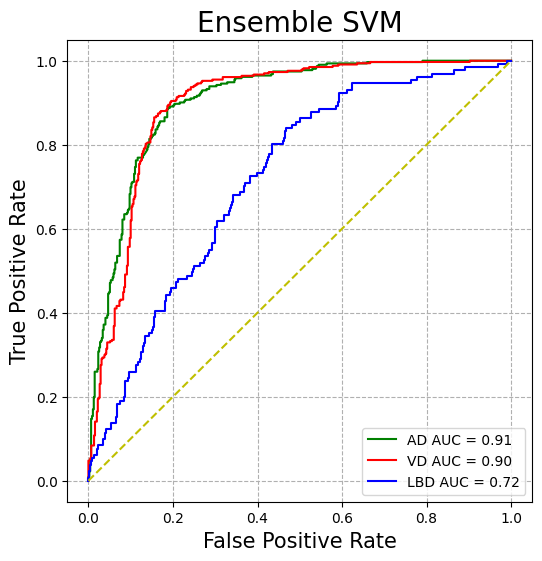

In [8]:
fpr, tpr, threshold = metrics.roc_curve(df.AD.values.tolist(), df.probAD.values.tolist())
roc_auc = metrics.auc(fpr, tpr)

fpr2, tpr2, threshold2 = metrics.roc_curve(df.VD.values.tolist(), df.probVD.values.tolist())
roc_auc2 = metrics.auc(fpr2, tpr2)

fpr3, tpr3, threshold3 = metrics.roc_curve(df.LBD.values.tolist(), df.probLBD.values.tolist())
roc_auc3 = metrics.auc(fpr3, tpr3)

plt.figure(figsize=(6, 6))
plt.title('Ensemble SVM', fontsize = 20)
plt.plot(fpr, tpr, 'g', label = 'AD AUC = %0.2f' % roc_auc)
plt.plot(fpr2, tpr2, 'r', label = 'VD AUC = %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'b', label = 'LBD AUC = %0.2f' % roc_auc3)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'y--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.grid(linestyle = '--')
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xlabel('False Positive Rate', fontsize = 15)
plt.show()

# Chart

/tmp/ipykernel_5066/555195725.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()], fontsize=12)
/tmp/ipykernel_5066/555195725.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()], fontsize=12)


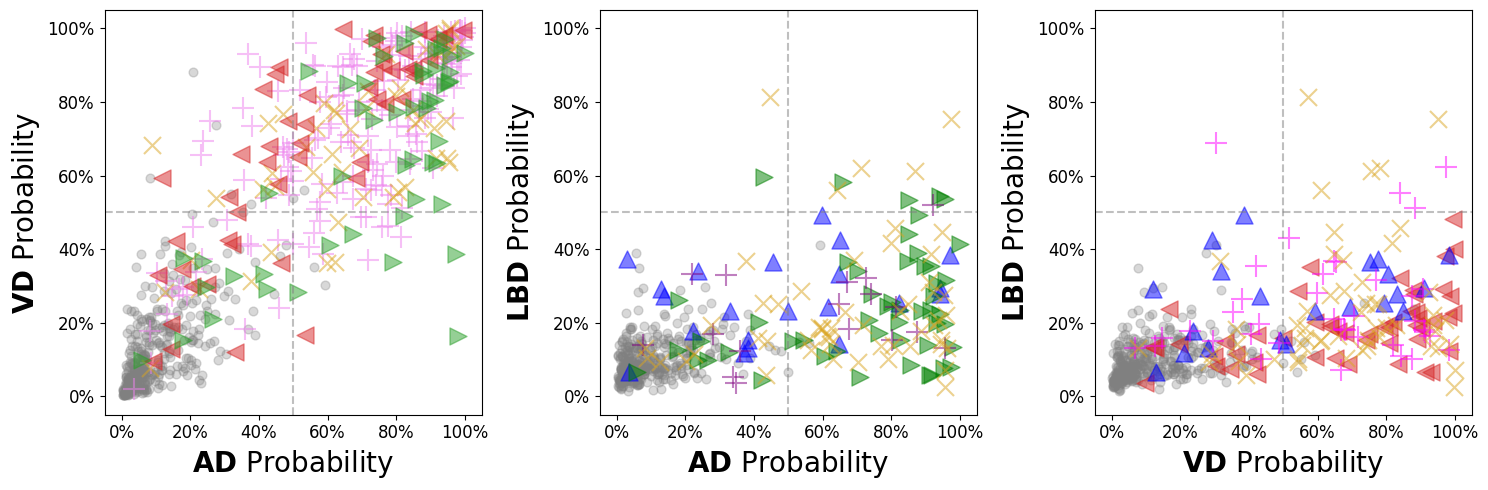

In [40]:
fig,axs = plt.subplots(ncols = 3,nrows=1,figsize = (15,5))
axs = axs.flatten()


s = 150    
f1,f2 ='probAD','probVD'

fs = 20

# axs[0].scatter(-100,-100, label = "CN", marker='o', alpha = 0.5, s =40, color = 'gray')
# axs[0].scatter(-100,-100, label = "AD", marker='>', alpha = 0.5, s =s, color = '#2CA02C')
# axs[0].scatter(-100,-100, label = "VD", marker='<', alpha = 0.5, s =s, color = '#D62728')
# axs[0].scatter(-100,-100, label = "LBD", marker='^', alpha = 0.5, s =s, color = 'blue')
# axs[0].scatter(-100,-100, label = "AD+VD", marker='+', alpha = 0.5, s =s+100, color = 'violet')
# axs[0].scatter(-100,-100, label = "AD+LBD", marker='+', alpha = 0.5, s =s+100, color = 'purple')
# axs[0].scatter(-100,-100, label = "VD+LBD", marker='+', alpha = 0.5, s =s+100, color = 'magenta')
# axs[0].scatter(-100,-100, label = "AD+VD+LBD", marker='x', alpha = 0.5, s =s, color = 'goldenrod')
# axs[0].legend(prop={'size': 20},bbox_to_anchor=(1, 0.53, 0.5, 0.5))

axs[0].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
             marker='o', alpha = 0.3, s =40, color = 'gray')

axs[0].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 0)][[f2]], 
             marker='+', alpha = 0.5, s =s+100, color = 'violet')

axs[0].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
            marker='x', alpha = 0.5, s =s, color = 'goldenrod')
axs[0].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f2]], 
             marker='<', alpha = 0.5, s =s, color = '#D62728')

axs[0].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
             marker='>', alpha = 0.5, s =s, color = '#2CA02C')

axs[0].set_xlabel(r'$\bf{AD}$ Probability', fontsize = fs)
axs[0].set_ylabel(r'$\bf{VD}$ Probability', fontsize = fs)    



f1,f2 ='probAD','probLBD'
axs[1].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
            marker='o', alpha = 0.3, s =40, color = 'gray')

axs[1].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f2]], 
             marker='^', alpha = 0.5, s =s, color = 'blue')

axs[1].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
            marker='>', alpha = 0.5, s =s, color = 'green')

axs[1].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 0)&(df['LBD'] == 1)][[f2]], 
             marker='+', alpha = 0.5, s =s+100, color = 'purple')

axs[1].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
             marker='x', alpha = 0.5, s =s, color = 'goldenrod')

axs[1].set_xlabel(r'$\bf{AD}$ Probability', fontsize = fs)
axs[1].set_ylabel(r'$\bf{LBD}$ Probability', fontsize = fs) 


f1,f2 ='probVD','probLBD'
axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 0)][[f2]], 
            marker='o', alpha = 0.3, s =40, color = 'gray')

axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 0)][[f2]], 
            marker='<', alpha = 0.5, s =s, color = '#D62728')

axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 0)&(df['LBD'] == 1)][[f2]], 
            marker='^', alpha = 0.5, s =s, color = 'blue')

axs[2].scatter(df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 0) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
             marker='+', alpha = 0.5, s =s+100, color = 'magenta')

axs[2].scatter(df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f1]],
            df.loc[(df['AD'] == 1) &(df['VD'] == 1)&(df['LBD'] == 1)][[f2]], 
             marker='x', alpha = 0.5, s =s, color = 'goldenrod')

axs[2].set_xlabel( r'$\bf{VD}$ Probability', fontsize = fs)
axs[2].set_ylabel(r'$\bf{LBD}$ Probability', fontsize = fs)
    


# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])
# plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
# plt.gca().set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()]) 

# axs[0].set_title("Deep Learning Chart", fontsize = 20)
# plt.grid(linestyle = '--')
for i in range(0,3):
    axs[i].axvline(x = 0.5, linestyle = '--', color='gray', alpha = 0.5)
    axs[i].axhline(y = 0.5, linestyle = '--', color='gray', alpha = 0.5)
    axs[i].set_xlim([-0.05,1.05])
    axs[i].set_ylim([-0.05,1.05])
    
for i in range(0,3):    
    axs[i].set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()], fontsize=12) 
    axs[i].set_xticklabels([f'{x:.0%}' for x in plt.gca().get_xticks()], fontsize=12) 

    
fig.tight_layout()

# Plot SVM coefficient Map

In [3]:
from scipy.ndimage import gaussian_filter

In [4]:
pth = '/media/dw/Data/BINC_T1/BINC/dropbox/DW/data_npy/T1_3DSminmax_ADVDLBD_Mlabel_10fold_0307v2/SVM/SVM_c0.01_'
ad_coef = np.zeros((65,77,65))
vd_coef = np.zeros((65,77,65))
lbd_coef = np.zeros((65,77,65))
for i in range(0,10):
    ad_coef += np.load(pth + "ad_coef"+str(i)+".npy").reshape((65,77,65))
    vd_coef += np.load(pth + "vd_coef"+str(i)+".npy").reshape((65,77,65))
    lbd_coef += np.load(pth + "lbd_coef"+str(i)+".npy").reshape((65,77,65))

In [5]:
mni = nib.load('/home/dw/Desktop/tools/mni_icbm152_nlin_sym_09c/d3_mni.nii')
mni_affine = mni.affine
mni_affine
mn = mni.get_fdata()
mn[mni == 0] = 'nan'

mask = nib.load('/home/dw/Desktop/tools/mni_icbm152_nlin_sym_09c/d3_mask.nii.gz')
mask = mask.get_fdata()
mask[mask > 0] = 1
mask_bool =mask.astype(bool)

coord_MRI = (-33,-30,-28,-26,-22,-18,-12,-8,-5,-3,1)

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=1000):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


cmap = plt.get_cmap('hot_r') #   
new_cmap = truncate_colormap(cmap, -1, 1)

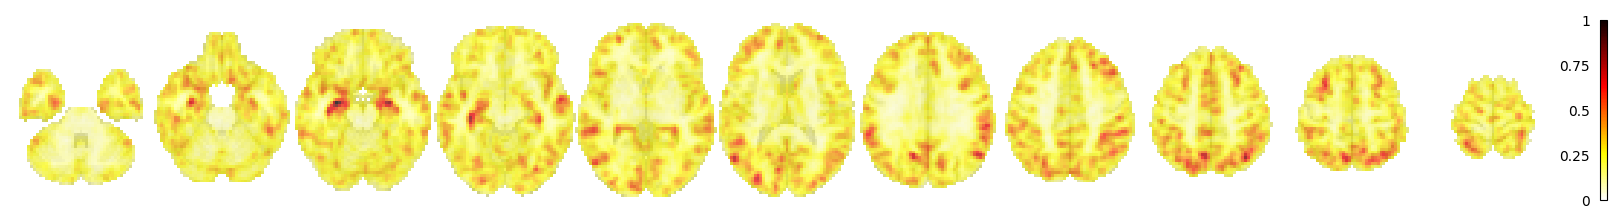

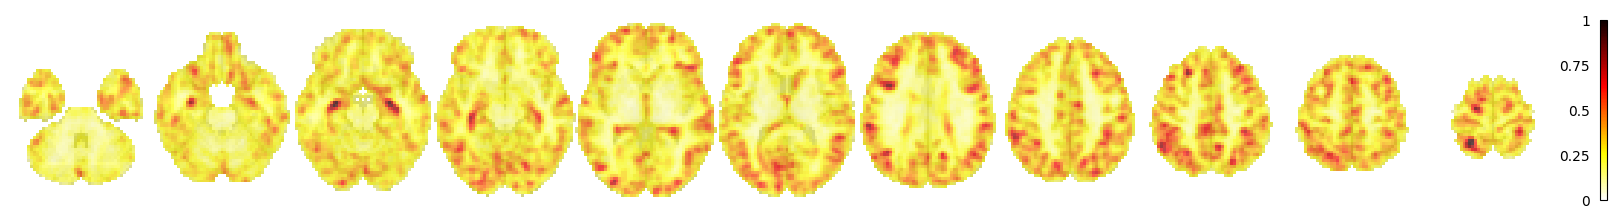

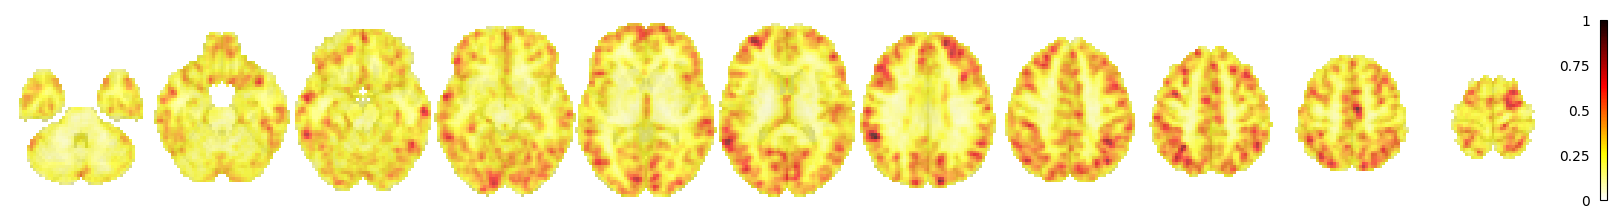

In [7]:
fig = plt.figure(figsize = (16,2))
m = ad_coef
m = abs(m)
m = gaussian_filter(m,sigma=0.8)
m = m*mask
max_ = np.max(m)
m = m/max_

mii = nib.Nifti1Image(m, affine = mni_affine)

plotting.plot_stat_map(mii, display_mode='z',cmap = new_cmap,threshold = 0,
                   bg_img = mni,annotate=False,black_bg=False, 
                   colorbar=True, figure = fig, 
#                    title = "SVM coefficient AD",
                   cut_coords=coord_MRI, draw_cross = False, alpha=0.7)

fig = plt.figure(figsize = (16,2))
m = vd_coef
m = abs(m)
m = gaussian_filter(m,sigma=0.8)
m = m*mask
max_ = np.max(m)
m = m/max_

mii = nib.Nifti1Image(m, affine = mni_affine)

plotting.plot_stat_map(mii, display_mode='z',cmap = new_cmap,threshold = 0,
                   bg_img = mni,annotate=False,black_bg=False, 
                   colorbar=True, figure = fig, 
#                    title = "SVM coefficient VD",
                   cut_coords=coord_MRI, draw_cross = False, alpha=0.7)

fig = plt.figure(figsize = (16,2))
m = lbd_coef
m = abs(m)
m = gaussian_filter(m,sigma=0.8)
m = m*mask
max_ = np.max(m)
m = m/max_

mii = nib.Nifti1Image(m, affine = mni_affine)

plotting.plot_stat_map(mii, display_mode='z',cmap = new_cmap,threshold = 0,
                   bg_img = mni,annotate=False,black_bg=False, 
                   colorbar=True, figure = fig, 
#                    title = "SVM coefficient LBD",
                   cut_coords=coord_MRI, draw_cross = False, alpha=0.7)